# Test adapted CosmiQNet

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_WKT
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

In [4]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [5]:
LABELS

['None',
 'Buildings',
 'Misc. Manmade structures',
 'Road',
 'Track',
 'Trees',
 'Crops',
 'Waterway',
 'Standing water',
 'Vehicle Large',
 'Vehicle Small']

In [6]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
vehicles_road_train = get_image_ids([10, 9, 3], gb)
print len(vehicles_road_train)

13


Input data :  3b and MS pensharpened

In [7]:
np.random.shuffle(vehicles_road_train)
ll = int(len(vehicles_road_train)*0.8)
train_ids = vehicles_road_train[:ll]
val_ids = vehicles_road_train[ll:]

In [8]:
tile_size = (128, 128)
# labels = np.array([9, 10, 3, 4])
labels = np.array([9, 10])
channels = np.array(list(range(8)))

In [9]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

def compute_mean_std(image_type, feature_wise, out_shape):
    s = ''
    if feature_wise:
        s = "_feature_wise"
    
    mean_fname = os.path.join(TRAIN_DATA, 'mean_%s_image%s.tif' % (image_type, s))
    std_fname = os.path.join(TRAIN_DATA, 'std_%s_image%s.tif' %  (image_type, s))
    if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_image, std_image = compute_mean_std_on_images(train_ids, image_type, feature_wise=feature_wise, out_shape=out_shape)
        logging.getLogger().setLevel(logging.ERROR)
        imwrite(mean_fname, mean_image)
        imwrite(std_fname, std_image)
    else:
        mean_image = GeoImage(mean_fname).get_data()
        std_image = GeoImage(std_fname).get_data()
    return mean_image, std_image

img_shape = (860*4, 860*4, 8)
feature_wise = True
mean_image, std_image = compute_mean_std('ms_pan', feature_wise, img_shape)
        
# print "RGB"    
# print mean_rgb_image.shape, std_rgb_image.shape
# print mean_rgb_image.min(), mean_rgb_image.max(), std_rgb_image.min(), std_rgb_image.max()

print "MS PAN" 
print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()

# print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

MS PAN
(3440, 3440, 8) (3440, 3440, 8)
323.844 805.357 26.6812 100.546


In [10]:
from data_utils import get_image_ids
from training_utils import tile_iterator


def generate_images(image_ids_to_use, batch_size, resolution_level=1):
    while True:
        
        X = np.zeros((batch_size, len(channels))+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, len(labels))+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use,
                              channels,
                              labels, 
                              presence_percentage=5.0,
                              image_type='ms_pan',
                              label_type='label',
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image,
                              resolution_levels=(resolution_level,),
                              verbose_image_ids=False
                             )
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]

In [11]:
batch_size = 5
train_data_gen = generate_images(train_ids, batch_size)

(5, 8, 128, 128) (5, 2, 128, 128)
-7.04032 17.1998 0.0 1.0


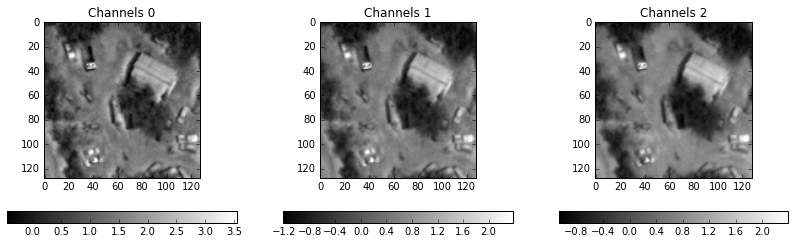

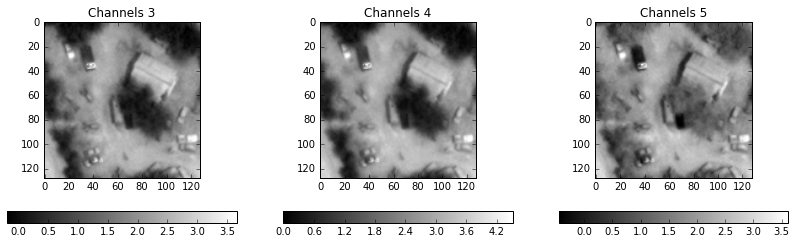

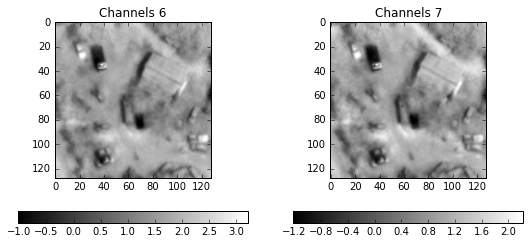

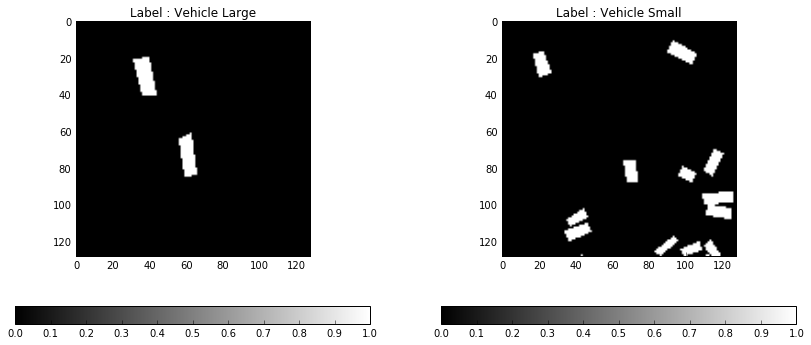

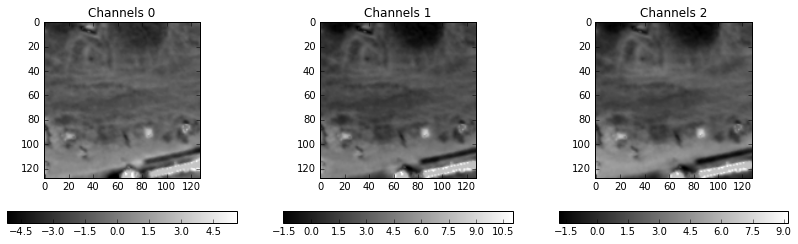

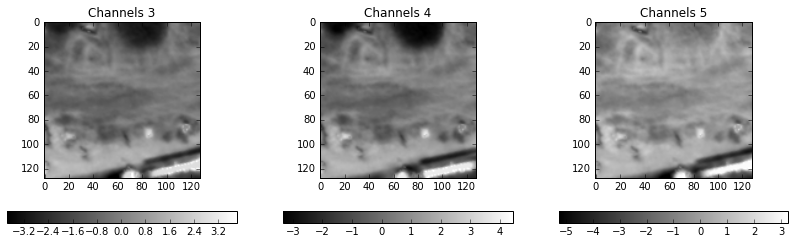

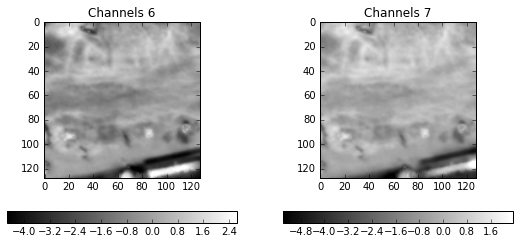

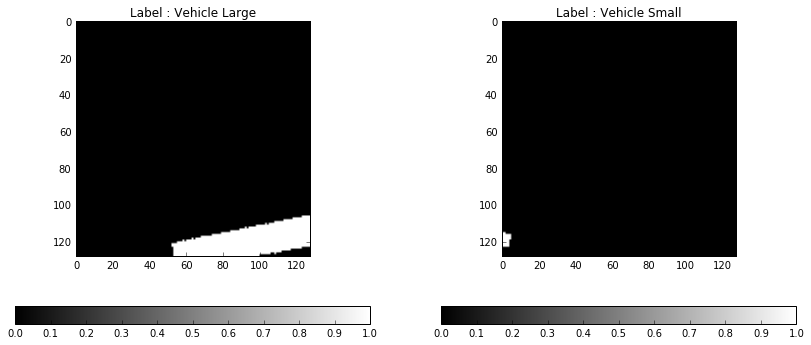

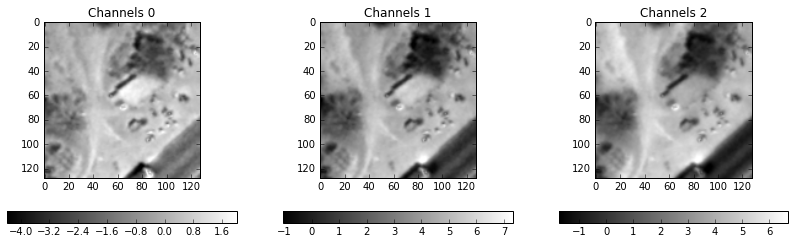

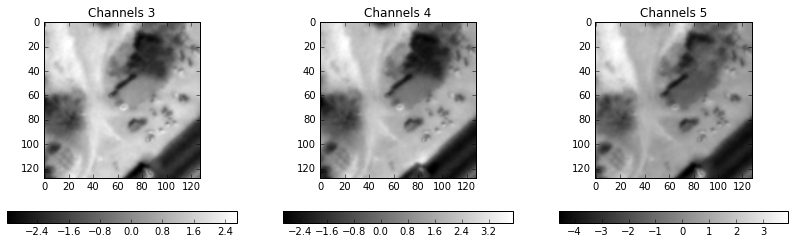

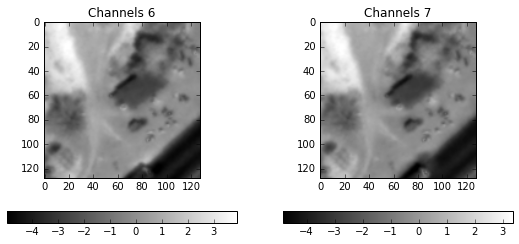

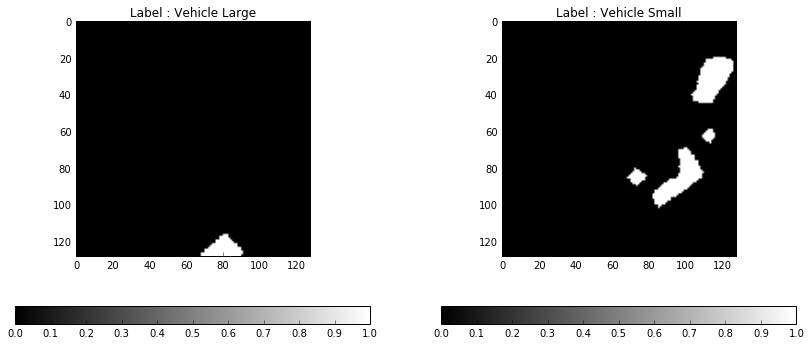

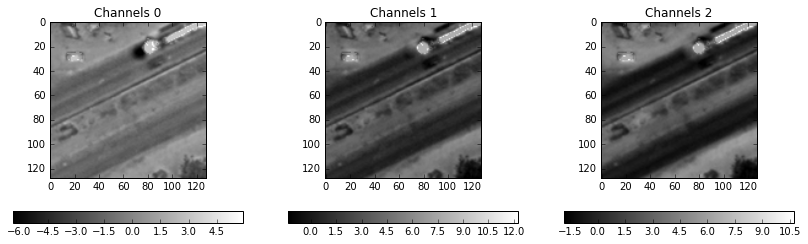

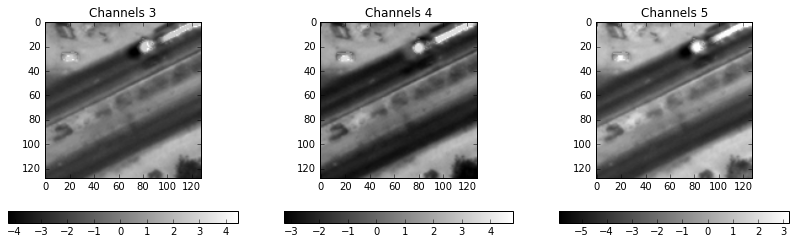

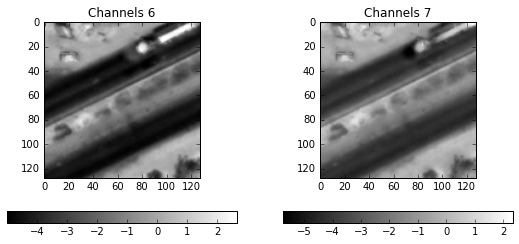

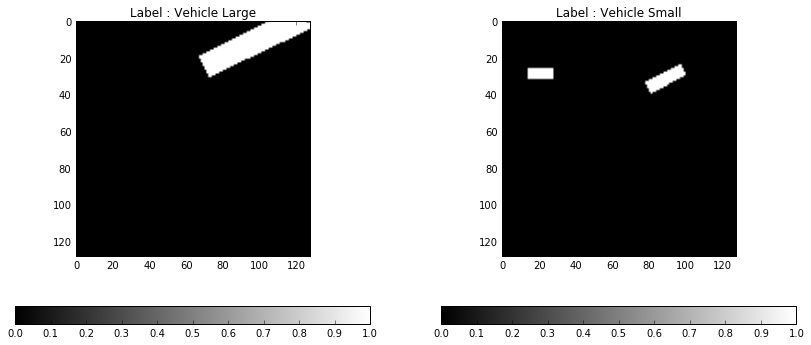

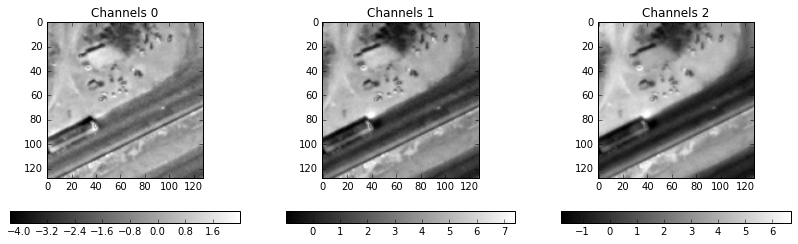

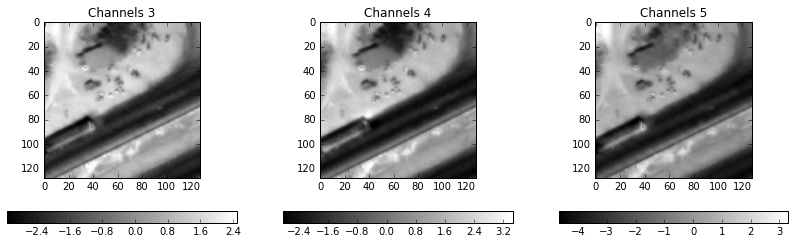

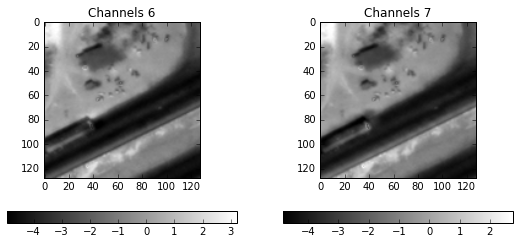

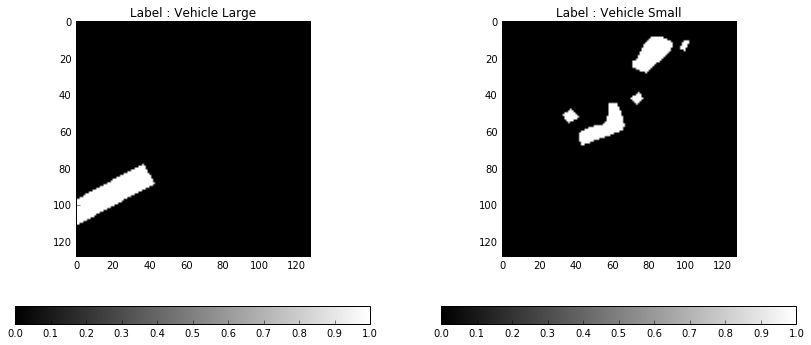

In [12]:
for X, Y in train_data_gen:
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _n_labels = len(labels)
    _n_channels = min(15, len(channels))
    for i in range(batch_size):
        
        n, m = 3, int(_n_channels * 1.0 / 3.0 + 1.0)
        for j in range(_n_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if _n_labels < 8:
            n, m = 1, _n_labels
        else:
            n, m = 3, int(_n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(_n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break
    
    # 6120_2_2 3244 1115
    # 6120_2_2 3275 1115

In [33]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

#from cosmiqnet import cosmiqnet_zero
from another_unet import unet

In [35]:
# model = unet(tile_size + (img_shape[2],), len(labels), n_layers=2, n_filters=64, size=3, beta=0.7)
model = unet(len(labels), len(channels), tile_size[1], tile_size[0])
weights_filename = os.path.join("weights", "vehicles_%i_ms.h5" % (labels[0]))

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 8, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_58 (Convolution2D) (None, 64, 64, 64)    4672        input_7[0][0]                    
____________________________________________________________________________________________________
leakyrelu_39 (LeakyReLU)         (None, 64, 64, 64)    0           convolution2d_58[0][0]           
____________________________________________________________________________________________________
convolution2d_59 (Convolution2D) (None, 128, 32, 32)   73856       leakyrelu_39[0][0]               
___________________________________________________________________________________________

In [37]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)

In [38]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [39]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 256
nb_val_samples = 64


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=10,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename + '.last')


4 256 64
Epoch 1/10
256/256 [==============================] - 2509s - loss: 0.1277 - jaccard_coef: 0.2438 - jaccard_coef_int: 0.2294 - recall: 0.3544 - precision: 0.8236 - val_loss: 0.1000 - val_jaccard_coef: 0.1647 - val_jaccard_coef_int: 0.1374 - val_recall: 0.2365 - val_precision: 0.6309
Epoch 2/10
256/256 [==============================] - 2269s - loss: 0.0378 - jaccard_coef: 0.5184 - jaccard_coef_int: 0.5549 - recall: 0.7030 - precision: 0.8782 - val_loss: 0.1050 - val_jaccard_coef: 0.1849 - val_jaccard_coef_int: 0.1704 - val_recall: 0.2784 - val_precision: 0.5371
Epoch 3/10
256/256 [==============================] - 2271s - loss: 0.0295 - jaccard_coef: 0.6051 - jaccard_coef_int: 0.6499 - recall: 0.7759 - precision: 0.8903 - val_loss: 0.0991 - val_jaccard_coef: 0.2464 - val_jaccard_coef_int: 0.2416 - val_recall: 0.3773 - val_precision: 0.5473
Epoch 4/10
256/256 [==============================] - 2383s - loss: 0.0226 - jaccard_coef: 0.6808 - jaccard_coef_int: 0.7321 - recall: 0.84

In [40]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 256
nb_val_samples = 64


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=10,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename + '.last')


4 256 64
Epoch 1/10
